<a href="https://colab.research.google.com/github/ldejuan/covid/blob/master/covid19_ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#
# Model on delta log of country Fatalities > Level
#


In [0]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import MultiTaskLasso,Ridge,SGDRegressor


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import interpolate



In [0]:
#read zip train and test data set from zip Archive
PATH_DATA= "./drive/My Drive/covid/"
fileNameZip = 'covid19-global-forecasting-week-3.zip'
archiveName = "%s%s"%(PATH_DATA,fileNameZip)
trainName= 'train.csv'
testName = 'test.csv'
submissionNane = 'submission.csv'
if zipfile.is_zipfile(archiveName):
  with zipfile.ZipFile(archiveName) as archive:
    dfTrain = pd.read_csv(archive.open(trainName,'r')).\
      rename(columns={"Country/Region":"Country_Region",
                      "Province/State":"Province_State"})
      
    dfTest  = pd.read_csv(archive.open(testName,'r')).\
      rename(columns={"Country/Region":"Country_Region",
                      "Province/State":"Province_State"})
    dfSubmission  = pd.read_csv(archive.open(submissionNane,'r'))

In [0]:
#
# Replace Province_State by None
#
dfTrain.replace(to_replace = np.nan, value ='none', inplace  =True)
dfTest.replace(to_replace = np.nan, value ='none', inplace  =True)
dfTrain['Date'] = pd.to_datetime(dfTrain['Date'])
dfTest['Date'] = pd.to_datetime(dfTest['Date'])


In [5]:
dfTrain.Date.max()

Timestamp('2020-03-30 00:00:00')

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#
# Create features per country
#
startFatalityThreshold = 5
def aggByCountry(x):

  dfResult = pd.DataFrame({'Fatalities': [np.sum(x.Fatalities.values)], 
                           'ConfirmedCases' : [np.sum(x.ConfirmedCases.values)]})
  return dfResult

dfTrainAgg = dfTrain.groupby(["Country_Region","Date"]).apply(aggByCountry)\
       .reset_index()\
       .drop(columns =['level_2'])

In [7]:
#
# Remove Countries with max fatalities < Level
#
startFatalityThreshold = 5
def removeCountry(x):
  max_Fatalities = np.sum(x.Fatalities.values)
  print ('%s : %s %s'%(x.Country_Region.iloc[0],max_Fatalities,(max_Fatalities <= startFatalityThreshold) ))
  x['removed'] = (max_Fatalities <= startFatalityThreshold)
  return x
df1 = dfTrainAgg.groupby(["Country_Region"]).apply(removeCountry)
mask = df1[df1.removed == True].index
dfTrainClean = df1.drop(mask)

Afghanistan : 25.0 False
Albania : 76.0 False
Algeria : 280.0 False
Andorra : 27.0 False
Angola : 4.0 True
Antigua and Barbuda : 0.0 True
Argentina : 131.0 False
Armenia : 9.0 False
Australia : 172.0 False
Austria : 498.0 False
Azerbaijan : 32.0 False
Bahamas : 0.0 True
Bahrain : 37.0 False
Bangladesh : 44.0 False
Barbados : 0.0 True
Belarus : 0.0 True
Belgium : 2440.0 False
Belize : 0.0 True
Benin : 0.0 True
Bhutan : 0.0 True
Bolivia : 5.0 True
Bosnia and Herzegovina : 37.0 False
Brazil : 775.0 False
Brunei : 3.0 True
Bulgaria : 63.0 False
Burkina Faso : 72.0 False
Cabo Verde : 7.0 False
Cambodia : 0.0 True
Cameroon : 18.0 False
Canada : 454.0 False
Central African Republic : 0.0 True
Chad : 0.0 True
Chile : 38.0 False
China : 142485.0 False
Colombia : 52.0 False
Congo (Brazzaville) : 0.0 True
Congo (Kinshasa) : 33.0 False
Costa Rica : 22.0 False
Cote d'Ivoire : 2.0 True
Croatia : 30.0 False
Cuba : 22.0 False
Cyprus : 33.0 False
Czechia : 79.0 False
Denmark : 452.0 False
Diamond Princ

In [0]:
#
# Remove entries with fatalities < max Fatalities
#
mask = dfTrainClean[dfTrainClean.Fatalities < startFatalityThreshold].index
dfTrainClean2 = dfTrainClean.drop(mask)


Text(0.5, 1.0, 'at Country Level : AsOfDate 2020-03-30 00:00:00')

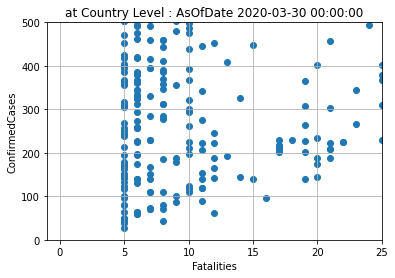

In [9]:
fig,ax = plt.subplots()
x = dfTrainClean2.Fatalities
y = dfTrainClean2.ConfirmedCases
ax.set_xlim([-1,25])
ax.set_ylim([0,500])
ax.scatter(x,y)
ax.grid()
ax.set_xlabel('Fatalities')
ax.set_ylabel('ConfirmedCases')
ax.set_title('at Country Level : AsOfDate %s'%dfTrainClean2.Date.max())


In [0]:
dfTrainClean.index


Int64Index([   64,    65,    66,    67,    68,    69,    70,    71,    72,
               73,
            ...
            18422, 18423, 18424, 18425, 18426, 18427, 18428, 18429, 18430,
            18431],
           dtype='int64', length=13120)

In [0]:
dfTrainClean2.head()

In [0]:
dfTrainClean2.columns

Index(['Country_Region', 'Date', 'Fatalities', 'ConfirmedCases', 'removed'], dtype='object')

In [28]:
#
# Make logarithm features and log difference par country & province
#
def log_corrected(x):
  y = np.log(x)
  y[y == -np.inf] = 0.
  return y

def makeLogFeatures(df):
  print ('processing ..%s '%(df.Country_Region.iloc[0]))
  df['log_Fatalities'] = log_corrected(df.Fatalities)
  df['log_ConfirmedCases'] = log_corrected(df.ConfirmedCases)

  df['diff_log_Fatalities'] = df['log_Fatalities'].diff(3).fillna(value = 0.)
  df['diff_log_ConfirmedCases'] = df['log_ConfirmedCases'].diff(3).fillna(value = 0.)

  return df
dfTrainFeatures = dfTrainClean2.groupby(["Country_Region"]).apply(makeLogFeatures)

processing ..Albania 
processing ..Algeria 
processing ..Andorra 
processing ..Argentina 
processing ..Australia 
processing ..Austria 
processing ..Bangladesh 
processing ..Belgium 
processing ..Bosnia and Herzegovina 
processing ..Brazil 
processing ..Bulgaria 
processing ..Burkina Faso 
processing ..Cameroon 
processing ..Canada 
processing ..Chile 
processing ..China 
processing ..Colombia 
processing ..Congo (Kinshasa) 
processing ..Croatia 
processing ..Cyprus 
processing ..Czechia 
processing ..Denmark 
processing ..Diamond Princess 
processing ..Dominican Republic 
processing ..Ecuador 
processing ..Egypt 
processing ..Finland 
processing ..France 
processing ..Germany 
processing ..Ghana 
processing ..Greece 
processing ..Honduras 
processing ..Hungary 
processing ..Iceland 
processing ..India 
processing ..Indonesia 
processing ..Iran 
processing ..Iraq 
processing ..Ireland 
processing ..Israel 
processing ..Italy 
processing ..Japan 
processing ..Jordan 
processing ..Korea,

In [0]:
#
# Make days_from_Fatalities
#
def calculateThreshold(df):
  dateMin = df.Date.min()
  if pd.isnull(dateMin):
    df['days_from_Fatalities'] = -1000.
  else:
    df['days_from_Fatalities']= (df.Date - dateMin) / np.timedelta64(1,'D')

  return df

dfTrainFeatures2 = dfTrainFeatures.groupby(["Country_Region"]).apply(calculateThreshold)  

In [0]:
dfTrainFeatures2.Country_Region.unique()

array(['Albania', 'Algeria', 'Andorra', 'Argentina', 'Australia',
       'Austria', 'Bangladesh', 'Belgium', 'Bosnia and Herzegovina',
       'Brazil', 'Bulgaria', 'Burkina Faso', 'Cameroon', 'Canada',
       'Chile', 'China', 'Colombia', 'Congo (Kinshasa)', 'Croatia',
       'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Finland', 'France',
       'Germany', 'Ghana', 'Greece', 'Honduras', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Jordan', 'Korea, South', 'Lebanon', 'Lithuania',
       'Luxembourg', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands',
       'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Saudi Arabia', 'Serbia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Taiwan*', 'Thailand', 'Tunisia',
       'Turkey', 'US', 'Ukraine', 'United Arab Emirates

In [0]:
#
# Create Forecast features and outputs 
#
def createShiftedFeature(df):
  df['diff_log_Fatalities_1'] = df.diff_log_Fatalities.shift(1)
  df['diff_log_Fatalities_3'] = df.diff_log_Fatalities.shift(3)
  df['diff_log_Fatalities_5'] = df.diff_log_Fatalities.shift(5)
# Output  
  df['diff_log_Fatalities_p1'] = df.diff_log_Fatalities.shift(-1)
  df['diff_log_Fatalities_p3'] = df.diff_log_Fatalities.shift(-3)
  df['diff_log_Fatalities_p5'] = df.diff_log_Fatalities.shift(-5)
  df['diff_log_Fatalities_p21'] = df.diff_log_Fatalities.shift(-21)

  df['diff_log_Confirmed_1'] = df.diff_log_ConfirmedCases.shift(1)
  df['diff_log_Confirmed_3'] = df.diff_log_ConfirmedCases.shift(3)
  df['diff_log_Confirmed_5'] = df.diff_log_ConfirmedCases.shift(5)
# Output
  df['diff_log_Confirmed_p1'] = df.diff_log_ConfirmedCases.shift(-1)
  df['diff_log_Confirmed_p3'] = df.diff_log_ConfirmedCases.shift(-3)
  df['diff_log_Confirmed_p5'] = df.diff_log_ConfirmedCases.shift(-5)
  df['diff_log_Confirmed_p21'] = df.diff_log_ConfirmedCases.shift(-21)

  return df

df2 = dfTrainFeatures2.groupby(["Country_Region"]).apply(createShiftedFeature)
dfLast = df2.groupby(['Country_Region']).tail(1).copy()

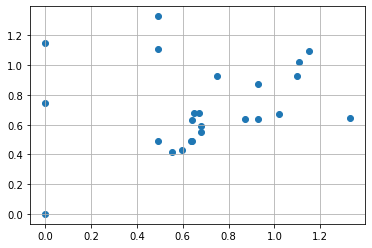

In [31]:
dfTestCntry = df2[(df2.Country_Region == 'France')]
fig,ax = plt.subplots()
x =dfTestCntry.diff_log_Fatalities_1
y= dfTestCntry.diff_log_Fatalities_p1
ax.scatter(x,y)
ax.grid()
fig.show()

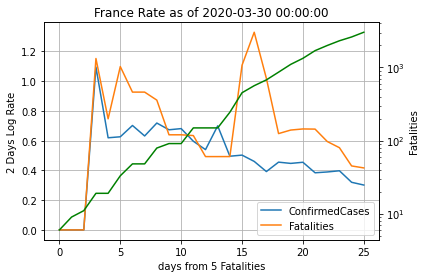

In [32]:
Cntry = 'France'
dfTestCntry = df2[(df2.Country_Region == Cntry)]
fig,ax1 = plt.subplots()
x =dfTestCntry.days_from_Fatalities
y= dfTestCntry.diff_log_ConfirmedCases
ax1.plot(x,y, label = 'ConfirmedCases')
y1 = dfTestCntry.diff_log_Fatalities
ax1.plot(x,y1, label = 'Fatalities')
ax1.grid()
ax1.set_title('%s Rate as of %s'%(Cntry,dfTestCntry.Date.max()))
ax1.legend()
ax1.set_xlabel('days from 5 Fatalities')
ax1.set_ylabel('2 Days Log Rate')
ax2 = ax1.twinx()
y2 = dfTestCntry.Fatalities
ax2.plot(x, y2, 'g-')
ax2.set_yscale('log')
ax2.set_ylabel('Fatalities')
fig.show()

In [33]:

dfTestCntry = df2[(df2.Country_Region == 'China')]
dfTestCntry[['diff_log_Fatalities','diff_log_Fatalities_p1']].corr()




,diff_log_Fatalities,diff_log_Fatalities_p1
diff_log_Fatalities,1.00000,0.90701
diff_log_Fatalities_p1,0.90701,1.00000


In [0]:
df2[df2.Country_Region == 'China'].Province_State.unique()

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu',
       'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai',
       'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin',
       'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang'], dtype=object)

In [0]:
df2.columns

Index(['Country_Region', 'Date', 'Fatalities', 'ConfirmedCases', 'removed',
       'log_Fatalities', 'log_ConfirmedCases', 'diff_log_Fatalities',
       'diff_log_ConfirmedCases', 'days_from_Fatalities',
       'diff_log_Fatalities_1', 'diff_log_Fatalities_3',
       'diff_log_Fatalities_5', 'diff_log_Fatalities_p1',
       'diff_log_Fatalities_p3', 'diff_log_Fatalities_p5',
       'diff_log_Fatalities_p21', 'diff_log_Confirmed_1',
       'diff_log_Confirmed_3', 'diff_log_Confirmed_5', 'diff_log_Confirmed_p1',
       'diff_log_Confirmed_p3', 'diff_log_Confirmed_p5',
       'diff_log_Confirmed_p21'],
      dtype='object')

In [0]:
#
# Test a multi-regression
#

#                      'diff_log_Fatalities_1',
#                      'diff_log_Fatalities_3',
#                      'diff_log_Fatalities_5',
#                      'diff_log_Confirmed_1',
#                      'diff_log_Confirmed_3',
#                      'diff_log_Confirmed_5'
numeric_features = ['diff_log_Fatalities', 
                      'diff_log_ConfirmedCases',
                    'diff_log_Fatalities_1',
                    'diff_log_Fatalities_3',
                   'diff_log_Confirmed_5' ]

categorical_features = ['Country_Region']
features = numeric_features + categorical_features

def modelPrediction(model_forecast):
  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())])


  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = True))])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features)])

  # Append classifier to preprocessing pipeline.
  # Now we have a full prediction pipeline.
  clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestRegressor(n_estimators = 200, max_depth= 100))])

#removed na_values
  df3 = df2.dropna(subset=features + [model_forecast])

  X_train, X_test, y_train, y_test = train_test_split(df3[features], df3[model_forecast], test_size=0.2)

  clf.fit(X_train, y_train)
  print("model score: %.3f" % clf.score(X_test, y_test))
  return clf
  


In [35]:
model_forecasts = ['diff_log_Fatalities_p1','diff_log_Fatalities_p3','diff_log_Fatalities_p5', 'diff_log_Fatalities_p21',
                   'diff_log_Confirmed_p1','diff_log_Confirmed_p3','diff_log_Confirmed_p5','diff_log_Confirmed_p21']
#model_forecasts = ['diff_log_Fatalities_p21']
#clf = modelPrediction(model_forecasts)
dfPredict = dfLast[['Country_Region','Date']].copy()
for model_forecast in model_forecasts:
  print ('processing ... %s'%model_forecast)
  dfPredict[model_forecast] = modelPrediction(model_forecast).predict(dfLast[features])

processing ... diff_log_Fatalities_p1
model score: 0.645
processing ... diff_log_Fatalities_p3
model score: 0.631
processing ... diff_log_Fatalities_p5
model score: 0.634
processing ... diff_log_Fatalities_p21
model score: 0.829
processing ... diff_log_Confirmed_p1
model score: 0.899
processing ... diff_log_Confirmed_p3
model score: 0.815
processing ... diff_log_Confirmed_p5
model score: 0.739
processing ... diff_log_Confirmed_p21
model score: 0.933


In [36]:
#dfPredict = dfLast[['Country_Region','Province_State','Date']].copy()
#dfResult = pd.DataFrame(data = clf.predict(dfLast[features]), index = dfPredict.index, columns = model_forecasts)
#df4 = dfPredict.merge(right = dfPredict, left_index = True, right_index= True)
#df4[df4.Country_Region == 'Spain']
dfPredict[dfPredict.Country_Region == 'France'].tail()

,Country_Region,Date,diff_log_Fatalities_p1,diff_log_Fatalities_p3,diff_log_Fatalities_p5,diff_log_Fatalities_p21,diff_log_Confirmed_p1,diff_log_Confirmed_p3,diff_log_Confirmed_p5,diff_log_Confirmed_p21
4070,France,2020-03-30,0.39156,0.41921,0.311936,0.145469,0.261949,0.236417,0.220758,0.117308


In [0]:
#
# Aggregate with date and dfTest first
#
df4.head()

NameError: ignored

In [0]:
dfPredict.to_csv('%spredict_ml_2.csv'%PATH_DATA, index = False)

In [0]:
#
# Transforming the results into rows
#
def aggByColumns(df):
  x=pd.DataFrame({'diff_log_Fatalities' : [df.diff_log_Fatalities_p1.iloc[0], df.diff_log_Fatalities_p3.iloc[0],
                                  df.diff_log_Fatalities_p5.iloc[0], df.diff_log_Fatalities_p21.iloc[0]], 
                'diff_log_ConfirmedCases' : [df.diff_log_Confirmed_p1.iloc[0], df.diff_log_Confirmed_p3.iloc[0],
                                    df.diff_log_Confirmed_p5.iloc[0], df.diff_log_Confirmed_p21.iloc[0]],
                'Date' : [df.Date.iloc[0] + np.timedelta64(1,'D'), df.Date.iloc[0] + np.timedelta64(3,'D'),
                         df.Date.iloc[0] + np.timedelta64(5,'D'),
                          df.Date.iloc[0] + np.timedelta64(21,'D')]
  })
  return x

dfResult = dfPredict.groupby(['Country_Region']).apply(aggByColumns).reset_index()

In [0]:
#
# get the output for submission and merge the results
#
# change rows in test first
dfResultAll = dfTest.merge(dfTrainFeatures, left_on=['Country_Region','Province_State','Date'], right_on=['Country_Region','Province_State','Date'], how= 'left')
dfResultAllM = dfResultAll.set_index(keys = ['Country_Region','Province_State','Date'])
dfResultM = dfResult.set_index(keys = ['Country_Region','Province_State','Date'])
dfResultAllM.update(dfResultM[['diff_log_ConfirmedCases','diff_log_Fatalities']])
dfResultAllM.reset_index(inplace = True, drop = False)

In [0]:
#
# Fill forward on diff_log_ConfirmedCases and diff_log_Fatalities backwards than forward
#
dfResultAllM[['diff_log_Fatalities','diff_log_ConfirmedCases']] = dfResultAllM[['diff_log_Fatalities','diff_log_ConfirmedCases']]\
.fillna(method = 'bfill')\
.fillna(method = 'ffill')

In [0]:
dfResultAllM[dfResultAllM.Country_Region == 'Spain'].tail(20)

In [0]:
#
# recalculate the ConfirmedCases and Fatalites from diff log
#
def completionForward(df):
  print ('processing ..%s'%df.Country_Region.iloc[0])
  cum_Fatalities = np.hstack(([0.], np.cumsum(df.diff_log_Fatalities.iloc[1:])))
  df['Fatalities'] = df.Fatalities.iloc[0]*np.exp(cum_Fatalities)
  cum_ConfirmedCases = np.hstack(([0.], np.cumsum(df.diff_log_ConfirmedCases.iloc[1:]))) 
  df['ConfirmedCases'] = df.ConfirmedCases.iloc[0]*np.exp(cum_ConfirmedCases)
  return df

submission = dfResultAllM.groupby(["Country_Region","Province_State"]).apply(completionForward)

In [0]:

submission[['Date','ForecastId','ConfirmedCases','Fatalities']].to_csv('%ssubmission.csv'%PATH_DATA)

print ('Success Finished')
  

Success Finished
